# Stabilize Inverted Cartpole with Deep Reinforcement Learning

In this notebook the environment of a double inverted cartpole is implemented.
The pendulum starts in a state very close to the unstable equilibrium $\theta_1, \theta_2 \approx 0$.
The goal is to create a reinforcement learning agent which will stabilize the cartpole in this inverted position. The trained neural network of the agent will observe the state $s_t$ of the physical system and will output the horizontal Force $f_t$ acting on the cart to control the double cartpole system.
No classical control theory will be used to achieve this.

## 1. Double Cartpole Environment

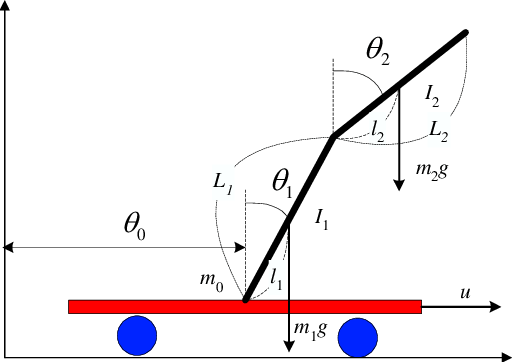

Quelle: Alexander Bogdanov - Optimal Control of a Double Inverted Pendulum on a Cart

https://www.researchgate.net/figure/Double-inverted-pendulum-on-a-cart_fig1_250107215

In [1]:
import numpy as np
from math import sin, cos
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
class CartPoleBalance:
    def __init__(self, max_force, max_phi, max_timesteps):
        self.state = None
        self.max_speed = 12.0 # [m/s], [rad/s]
        self.max_x = 3.0
        self.max_phi = max_phi
        self.max_force = max_force # [N]
        self.max_timesteps = max_timesteps
        
        self.action_space_low = np.array([-self.max_force])
        self.action_space_high = np.array([self.max_force])
        
        self.observation_space_high = np.array([self.max_x, self.max_phi, self.max_phi, self.max_speed, self.max_speed, self.max_speed])
        self.observation_space_low = - np.array([self.max_x, self.max_phi, self.max_phi, self.max_speed, self.max_speed, self.max_speed])
        
        self.dt = 0.02
        self.steps = 0
        
        self.viewer = None
        self.state=None
    
    def step(self, action):
        self.steps += 1
        q, theta1, theta2, dq, dtheta1, dtheta2 = self.state
        
        # force is bounded due to maximum motor torque of actuator
        F = np.clip(action, -self.max_force, self.max_force)[0]
        
        x0 = [q, theta1, theta2, dq, dtheta1, dtheta2]
        integration_timesteps = np.linspace(0, self.dt, 8)
        X = odeint(self.cartpole_dXdt, x0, integration_timesteps, args=(F,))
        
        # pick last elements of trajectory
        q = X[-1, 0]  
        theta1 = X[-1, 1]
        theta2 = X[-1, 2]
        dq = X[-1, 3]
        dtheta1 = X[-1, 4]
        dtheta2 = X[-1, 5]
        
        self.state = np.array([q, theta1, theta2, dq, dtheta1, dtheta2])
        
        # epsidoe ends when done = True
        done = bool(
            q < -self.max_x
            or q > self.max_x
            or theta1 < -self.max_phi
            or theta1 > self.max_phi
            or theta2 < -self.max_phi
            or theta2 > self.max_phi
            or self.steps >= self.max_timesteps)
        
        # reward function of transition s_t, action --> s_t+1
        #reward = 1.0 if not done else 0.0 # funktioniert
        if not done:
            reward = 1.0 - (q/self.max_x)**2
        elif done and self.steps >= self.max_timesteps:
            reward = 100.0
        elif done and self.steps < self.max_timesteps:
            reward = -100
        #reward = 1.0 - 0.5*dx**2 if not done else -10.0 # funktioniert gut
        #reward = 1.0 - 1.0*dx**2 - 1.2*x**2 - 10.0*phi**2 if not done else -20
        #if self.steps >= self.max_timesteps:
        #    reward = reward + 80
            
        # Swing up: https://ww2.mathworks.cn/help/reinforcement-learning/ug/train-ddpg-agent-to-swing-up-and-balance-cart-pole-system.html
        
        return self.state, reward, done
        
    
    def cartpole_dXdt(self, X, t, u):
        m, m1, m2 = 0.6, 0.853, 0.51
        g = 9.81
        d1, d2, d3 = 0.003, 0.003, 0.003
        l1, l2 = 0.35, 0.48
        
        q, theta1, theta2, dq, dtheta1, dtheta2 = X
    
        ddq = ((2*l1*l2*m1*u + l1*l2*m2*u - d2*dtheta1*l2*m2*cos(theta1 - 2*theta2) + 2*dtheta1**2*l1**2*l2*m1**2*sin(theta1) 
            -d3*dtheta2*l1*m1*cos(2*theta1 - theta2) - d3*dtheta2*l1*m2*cos(2*theta1 - theta2) - 2*d1*dq*l1*l2*m1 
            -d1*dq*l1*l2*m2 - l1*l2*m2*u*cos(2*theta1 - 2*theta2) - g*l1*l2*m1**2*sin(2*theta1) 
            +2*d2*dtheta1*l2*m1*cos(theta1) + d2*dtheta1*l2*m2*cos(theta1) + d3*dtheta2*l1*m1*cos(theta2) 
            +d3*dtheta2*l1*m2*cos(theta2) + 2*dtheta1**2*l1**2*l2*m1*m2*sin(theta1) + dtheta2**2*l1*l2**2*m1*m2*sin(theta2)
            +dtheta2**2*l1*l2**2*m1*m2*sin(2*theta1 - theta2) - g*l1*l2*m1*m2*sin(2*theta1) 
            + d1*dq*l1*l2*m2*cos(2*theta1 - 2*theta2))/(l1*l2*(2*m*m1 + m*m2 + m1*m2 - m1**2*cos(2*theta1) + m1**2 
                                                               - m1*m2*cos(2*theta1) - m*m2*cos(2*theta1 - 2*theta2))))
    
        ddtheta1 =  (-(2*d2*dtheta1*l2*m + 2*d2*dtheta1*l2*m1 + d2*dtheta1*l2*m2 - 2*d3*dtheta2*l1*m*cos(theta1 - theta2) -
                   d3*dtheta2*l1*m1*cos(theta1 - theta2) - d3*dtheta2*l1*m2*cos(theta1 - theta2) - 
                   l1*l2*m2*u*cos(theta1 -2*theta2) - d2*dtheta1*l2*m2*cos(2*theta2) - 2*g*l1*l2*m1**2*sin(theta1) 
                   + dtheta1**2*l1**2*l2*m1**2*sin(2*theta1) + d3*dtheta2*l1*m1*cos(theta1 + theta2) + 
                   d3*dtheta2*l1*m2*cos(theta1 + theta2) + 2*l1*l2*m1*u*cos(theta1) + l1*l2*m2*u*cos(theta1) - 
                   2*d1*dq*l1*l2*m1*cos(theta1) - d1*dq*l1*l2*m2*cos(theta1) + 
                   2*dtheta2**2*l1*l2**2*m*m2*sin(theta1 - theta2) + dtheta2**2*l1*l2**2*m1*m2*sin(theta1 - theta2) - 
                   2*g*l1*l2*m*m1*sin(theta1) - g*l1*l2*m*m2*sin(theta1) - 2*g*l1*l2*m1*m2*sin(theta1) + 
                   d1*dq*l1*l2*m2*cos(theta1 - 2*theta2) + dtheta1**2*l1**2*l2*m1*m2*sin(2*theta1) - 
                   g*l1*l2*m*m2*sin(theta1 - 2*theta2) + dtheta1**2*l1**2*l2*m*m2*sin(2*theta1 - 2*theta2) + 
                   dtheta2**2*l1*l2**2*m1*m2*sin(theta1 + theta2))/(l1**2*l2*(2*m*m1 + m*m2 + m1*m2 - m1**2*cos(2*theta1) + 
                                                            m1**2 - m1*m2*cos(2*theta1) - m*m2*cos(2*theta1 - 2*theta2))))
    
        ddtheta2 =((d2*dtheta1*l2*m2**2*cos(theta1 - theta2) - d3*dtheta2*l1*m2**2 - d2*dtheta1*l2*m2**2*cos(theta1 + theta2) -
                l1*l2*m2**2*u*cos(theta2) - d3*dtheta2*l1*m1**2 - 2*d3*dtheta2*l1*m*m1 - 2*d3*dtheta2*l1*m*m2 -
                2*d3*dtheta2*l1*m1*m2 + d3*dtheta2*l1*m1**2*cos(2*theta1) + d3*dtheta2*l1*m2**2*cos(2*theta1) +
                l1*l2*m2**2*u*cos(2*theta1 - theta2) + dtheta2**2*l1*l2**2*m*m2**2*sin(2*theta1 - 2*theta2) -
                d2*dtheta1*l2*m1*m2*cos(theta1 + theta2) - d1*dq*l1*l2*m2**2*cos(2*theta1 - theta2) -
                g*l1*l2*m*m2**2*sin(2*theta1 - theta2) - l1*l2*m1*m2*u*cos(theta2) + 2*d2*dtheta1*l2*m*m2*cos(theta1 - theta2)
                + d2*dtheta1*l2*m1*m2*cos(theta1 - theta2) + d1*dq*l1*l2*m2**2*cos(theta2) + 2*d3*dtheta2*l1*m1*m2*cos(2*theta1)
                + 2*dtheta1**2*l1**2*l2*m*m2**2*sin(theta1 - theta2) + g*l1*l2*m*m2**2*sin(theta2) +
                l1*l2*m1*m2*u*cos(2*theta1 - theta2) - d1*dq*l1*l2*m1*m2*cos(2*theta1 - theta2) -
                g*l1*l2*m*m1*m2*sin(2*theta1 - theta2) + d1*dq*l1*l2*m1*m2*cos(theta2)
                +2*dtheta1**2*l1**2*l2*m*m1*m2*sin(theta1 - theta2) + g*l1*l2*m*m1*m2*sin(theta2))
               /(l1*l2**2*m2*(2*m*m1 + m*m2 + m1*m2 - m1**2*cos(2*theta1) + m1**2 - m1*m2*cos(2*theta1)
                              - m*m2*cos(2*theta1 - 2*theta2))))
        
        return float(dq), float(dtheta1), float(dtheta2), float(ddq), float(ddtheta1), float(ddtheta2)
    
    def reset(self):
        start_deg = 5
        self.steps = 0
        high = np.array([0.1, np.deg2rad(start_deg), np.deg2rad(start_deg), 0.001, 0.001, 0.001]) # q, theta1, theta2, dq, dtheta1, dtheta2
        self.state = np.random.uniform(low=-high, high=high)
        #self.state = np.array([0.0, np.deg2rad(90), np.deg2rad(90), 0.0, 0.0, 0.0]) ##########################
        return self.state
    
    def render(self, mode='human'):
        screen_width = 600
        screen_height = 600

        world_width = self.max_x * 2
        scale = screen_width/world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * (2 * 0.42)
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            
            
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
            pole2 = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole2.set_color(.2, .6, .4)
            self.poletrans2 = rendering.Transform(translation=(0, polelen))
            pole2.add_attr(self.poletrans2)
            pole2.add_attr(self.poletrans)
            pole2.add_attr(self.carttrans)
            self.viewer.add_geom(pole2)
            
            
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            
            
            self.track = rendering.Line((0, 3*carty), (screen_width, 3*carty))  #4*
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self._pole_geom = pole
            self._pole_geom2 = pole2

        if self.state is None:
            return None

        # Edit the pole polygon vertex
        pole = self._pole_geom
        l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
        pole.v = [(l, b), (l, t), (r, t), (r, b)]
        
        pole2 = self._pole_geom2
        l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
        pole2.v = [(l, b), (l, t), (r, t), (r, b)]

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, 3*carty)
        self.poletrans.set_rotation(-x[1])
        self.poletrans2.set_rotation(-x[2]+x[1])

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

## 2. Deep Reinforcement Learning Agent - Soft Actor-Critic (SAC)

Implementation of newest style of SAC with two Q Networks and temperature parameter alpha optimization/tuning.

In [3]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_probability as tfp  # Distributions with reparam trick to gradients flow through
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers  # for layer weight initializing
import tensorflow.keras.losses as losses
import gym
import pybullet_envs
import matplotlib.pyplot as plt

In [4]:
class ReplayBuffer:
    def __init__(self, n_actions, input_shape, max_size=1000000):
        self.mem_size = max_size

        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

        self.n_count = 0

    def store_transition(self, state, action, reward, state_, done):
        index = self.n_count % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.n_count += 1

    def sample_buffer(self, batch_size=256):
        max_mem = min(self.n_count, self.mem_size)
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [5]:
class CriticNetwork(tf.keras.Model):
    def __init__(self, n_states, n_actions, fc1_dims, fc2_dims, network_name, chkpt_dir='tmp/SAC', init_w=3e-3):
        super(CriticNetwork, self).__init__()

        self.network_name = network_name
        self.checkpoint_dir = chkpt_dir
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)
        self.checkpoint_file = os.path.join(self.checkpoint_dir, network_name + '_SAC')

        self.fc1 = Dense(units=fc1_dims, activation='relu', input_shape=(n_states + n_actions, ))
        self.fc2 = Dense(units=fc2_dims, activation='relu')
        self.q = Dense(units=1,
                       kernel_initializer=initializers.RandomUniform(minval=-init_w, maxval=init_w), # Änderung
                       bias_initializer=initializers.RandomUniform(minval=-init_w, maxval=init_w))

    def call(self, state, action):
        inputs = tf.concat([state, action], axis=1)
        x = self.fc1(inputs)
        x = self.fc2(x)
        return self.q(x) 


class ActorNetwork(tf.keras.Model):
    def __init__(self,
                 n_states,
                 n_actions,
                 fc1_dims,
                 fc2_dims,
                 network_name,
                 chkpt_dir='tmp/SAC',
                 init_w=3e-3,
                 log_std_min=-20,
                 log_std_max=2):
        super(ActorNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

        self.network_name = network_name
        self.checkpoint_dir = chkpt_dir
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)
        self.checkpoint_file = os.path.join(self.checkpoint_dir, network_name + '_SAC')
        
        self.fc1 = Dense(units=fc1_dims, activation='relu', input_shape=(n_states, ))
        self.fc2 = Dense(units=fc2_dims, activation='relu')
        
        self.mu = Dense(units=n_actions,
                      kernel_initializer=initializers.RandomUniform(minval=-init_w, maxval=init_w),
                      bias_initializer=initializers.RandomUniform(minval=-init_w, maxval=init_w))
        
        self.log_std = Dense(units=n_actions,
                      kernel_initializer=initializers.RandomUniform(minval=-init_w, maxval=init_w),
                      bias_initializer=initializers.RandomUniform(minval=-init_w, maxval=init_w))
        

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        mu = self.mu(x)
        
        log_std = self.log_std(x)
        log_std = tf.clip_by_value(log_std, clip_value_min=self.log_std_min, clip_value_max=self.log_std_max)
        std = tf.exp(log_std)
        
        normal = tfp.distributions.Normal(mu, std)  # make Gaussian distribution of mu, and sigma for actions
        
        z = normal.sample()  # sample from distribution with reparam trick
        action = tf.tanh(z)  # bound actions to [-1, +1]
        
        # correct log_probs because of bounding the actions
        log_prob = normal.log_prob(z) - tf.math.log(1 - tf.math.square(action) + 1e-6)  # Ist dasselbe!
        log_prob = tf.reduce_sum(log_prob, axis=1, keepdims=True) # tf.reduce_sum() or tf.reduce_mean()

        return action, log_prob, mu

In [6]:
class Agent:
    """ 2019 State-of-the-Art Implementation of SAC with optimized temperature

    """
    def __init__(self,
                 env,
                 lr_Q = 3e-4,
                 lr_actor = 3e-4,
                 lr_a = 3e-4,
                 gamma=0.99,
                 tau=0.005,
                 layer1_size=256,
                 layer2_size=256,
                 batch_size=256,
                 max_size=1000000,
                 warmup=1000,
                 policy_delay=1,
                 minimum_entropy=None):

        self.env = env
        self.action_range = [env.action_space_low, env.action_space_high]

        self.n_states = env.observation_space_low.shape[0]
        self.n_actions = env.action_space_low.shape[0]

        self.min_action = env.action_space_low
        self.max_action = env.action_space_high

        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.warmup = warmup
        self.time_step = 0
        self.update_step = 0
        self.policy_delay = policy_delay

        self.policy_net = ActorNetwork(n_states=self.n_states, n_actions=self.n_actions,
                                       fc1_dims=layer1_size, fc2_dims=layer2_size, network_name='Actor')

        self.q_net1 = CriticNetwork(n_states=self.n_states, n_actions=self.n_actions,
                                    fc1_dims=layer1_size, fc2_dims=layer2_size, network_name='Critic_1')

        self.q_net2 = CriticNetwork(n_states=self.n_states, n_actions=self.n_actions,
                                    fc1_dims=layer1_size, fc2_dims=layer2_size, network_name='Critic_2')

        self.target_q_net1 = CriticNetwork(n_states=self.n_states, n_actions=self.n_actions,
                                           fc1_dims=layer1_size, fc2_dims=layer2_size, network_name='Target_Critic_1')

        self.target_q_net2 = CriticNetwork(n_states=self.n_states, n_actions=self.n_actions,
                                           fc1_dims=layer1_size, fc2_dims=layer2_size, network_name='Target_Critic_2')

        self.replay_buffer = ReplayBuffer(n_actions=self.n_actions,
                                          input_shape=self.n_states,
                                          max_size=max_size)
        
        self.policy_net.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_actor))
        self.q_net1.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_Q))
        self.q_net2.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_Q))

        self.update_target_network_parameters(tau=1)  # copy parameters to target networks

        # entropy temperature parameter alpha
        #self.log_alpha = tf.Variable(0.0, dtype=tf.float32)
        print(-tf.constant(env.action_space_low.shape[0], dtype=tf.float32))
        
        self.log_alpha = tf.Variable(tf.zeros(1), trainable=True)
        self.minimum_entropy = -tf.reduce_prod(tf.convert_to_tensor(env.action_space_low.shape, dtype=tf.float32))
        self.minimum_entropy = -tf.reduce_prod(tf.convert_to_tensor(env.action_space_low.shape, dtype=tf.float32)) if minimum_entropy is None else minimum_entropy
        print('Minimum Entropy set to: ', self.minimum_entropy)
        self.alpha_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_a)
        self.alpha = tf.exp(self.log_alpha).numpy()
        print('alpha: ', self.alpha)
        

    def choose_action(self, state):
        if self.time_step < self.warmup:
            actions = np.random.uniform(low=-1.0, high=1.0, size=self.n_actions)  # "random uniform distribution over all valid actions"
            actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        else:
            state = tf.convert_to_tensor(state, dtype=tf.float32)
            state = tf.expand_dims(state, axis=0)
            actions, _, _ = self.policy_net(state)

        self.time_step += 1
        if self.time_step == self.warmup:
            print('No warmup anymore!')
        a = self.rescale_action(actions[0].numpy())
        return a
    
    def control(self, state):
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        state = tf.expand_dims(state, axis=0)
        _, _, mu = self.policy_net(state)
        return self.rescale_action(mu[0].numpy())

    def scale_action(self, action):
        """ Scale all actions to [-1., +1.]

        :param action: unscaled actions
        :return: scaled actions all in range -1. .. +1.
        """
        #old = 2 * (action - self.min_action) / (self.max_action - self.min_action) - 1.0
        scale = (2 * action - (self.action_range[1] + self.action_range[0])) / (self.action_range[1] - self.action_range[0])
        return scale

    def rescale_action(self, action):
        """ Rescale all scaled actions to environment actionspace values

        :param action: scaled actions
        :return: rescaled actions all in range min_action .. max_action
        """
        #old = (action + 1.0) * (self.max_action - self.min_action) / 2.0 + self.min_action
        rescale = action * (self.action_range[1] - self.action_range[0]) / 2.0 + \
               (self.action_range[1] + self.action_range[0]) / 2.0
        return rescale

    def remember(self, state, action, reward, new_state, done):
        action = self.scale_action(action)  # ÄNDERUNG! Funktioniert das mit?
        self.replay_buffer.store_transition(state, action, reward, new_state, done)

    def update_target_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau
        
        weights = []
        for theta_target, theta in zip(self.target_q_net1.get_weights(), 
                                       self.q_net1.get_weights()):
            theta_target = tau*theta + (1-tau)*theta_target
            weights.append(theta_target)
        self.target_q_net1.set_weights(weights)
        
        weights = []
        for theta_target, theta in zip(self.target_q_net2.get_weights(),
                                       self.q_net2.get_weights()):
            theta_target = tau*theta + (1-tau)*theta_target
            weights.append(theta_target)
        self.target_q_net2.set_weights(weights)
        
        #weights = []
        #theta_target = self.target_q_net1.weights
        #for i, theta in enumerate(self.q_net1.weights):
        #    weights.append(tau*theta + (1-tau)*theta_target[i])
        #self.target_q_net1.set_weights(weights)
        # 
        #weights = []
        #theta_target = self.target_q_net2.weights
        #for i, theta in enumerate(self.q_net2.weights):
        #    weights.append(tau*theta + (1-tau)*theta_target[i])
        #self.target_q_net2.set_weights(weights)
        

    def save_models(self):
        print('...save actor...')
        self.policy_net.save_weights('./Actor')

    def load_models(self):
        self.policy_net.load_weights('./Actor')

    def learn(self):
        if self.replay_buffer.n_count < self.batch_size:
            return
        elif self.replay_buffer.n_count == self.batch_size:
            print('Buffer Size equals batch Size! - Learning begins :)')
            return
        
        # sample batch from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample_buffer(batch_size=self.batch_size)
        
        # convert batchs from 2D numpy arrays to tensorflow tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        
        # expand rewards and dones from 1D numpy arrays to 2D tensors and reshape them
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        rewards = tf.expand_dims(rewards, axis=0)
        rewards = tf.reshape(rewards, [self.batch_size, 1])
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        dones = tf.expand_dims(dones, axis=0)
        dones = tf.reshape(dones, [self.batch_size, 1])
        
        
        ## Update critic networks Q1 & Q2
        with tf.GradientTape(persistent=True) as tape_Q:
            next_actions, next_log_pi, _ = self.policy_net(next_states)
            Q1_next = self.target_q_net1(next_states, next_actions)
            Q2_next = self.target_q_net2(next_states, next_actions)
            next_q_target = tf.minimum(Q1_next, Q2_next) - self.alpha * next_log_pi
            expected_q = tf.stop_gradient(rewards + (1 - dones) * self.gamma * next_q_target)
            
            curr_q1 = self.q_net1(states, actions)
            curr_q2 = self.q_net2(states, actions)
            
            q1_loss = tf.reduce_mean((curr_q1 - expected_q)**2)
            q2_loss = tf.reduce_mean((curr_q2 - expected_q)**2)  # tf.square()
            q_loss = q1_loss + q2_loss
        
        grad_Q1 = tape_Q.gradient(q_loss, self.q_net1.trainable_variables)
        grad_Q2 = tape_Q.gradient(q_loss, self.q_net2.trainable_variables)
        
        self.q_net1.optimizer.apply_gradients(zip(grad_Q1, self.q_net1.trainable_variables))
        self.q_net2.optimizer.apply_gradients(zip(grad_Q2, self.q_net2.trainable_variables))
        

        ## Update policy network and polyak update target Q networks less frequently (like in TD3 --> Delayed SAC)
        if self.update_step % self.policy_delay == 0:
            with tf.GradientTape() as tape_policy:
                new_actions, log_pi, _ = self.policy_net(states)
                Q1 = self.q_net1(states, new_actions)
                Q2 = self.q_net2(states, new_actions)
                Q_min = tf.minimum(Q1, Q2)
                loss_policy = tf.reduce_mean(self.alpha * log_pi - Q_min)
            
            grad_policy = tape_policy.gradient(loss_policy, self.policy_net.trainable_variables)
            self.policy_net.optimizer.apply_gradients(zip(grad_policy, self.policy_net.trainable_variables))

            
            self.update_target_network_parameters()  # update target networks

        ## Update temperature
        with tf.GradientTape() as tape:
            _, log_pi_a, _ = self.policy_net(states)
            alpha_loss = tf.reduce_mean(self.log_alpha*(-log_pi_a - self.minimum_entropy))
            
        grads = tape.gradient(alpha_loss, [self.log_alpha])
        self.alpha_optimizer.apply_gradients(zip(grads, [self.log_alpha]))
        self.alpha = tf.exp(self.log_alpha).numpy()

        self.update_step += 1  # Keep track of the number of network updates


In [7]:
def plot_learning_curve(scores, figure_file, Ylabel, color, avg_color=None , plot_folder='./plots', Xlabel='Episodes'):
    if not os.path.exists(plot_folder):
        os.makedirs(plot_folder)
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i - 100):i + 1])

    plt.figure()
    plt.plot(scores, color=color)
    if avg_color is not None:
        plt.plot(running_avg, color=avg_color)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    plt.savefig(figure_file)

In [8]:
n_games = 3000

env = CartPoleBalance(max_force=50.0, max_phi=np.deg2rad(18), max_timesteps=500)  ## 200 funktioniert gut!

agent = Agent(env=env)

filename_return = '_SAC_' + 'return_' 
filename_alpha = '_SAC_' + 'alpha_' 
figure_file_return = 'plots/' + filename_return
figure_file_alpha = 'plots/' + filename_alpha

best_score = -100000.0
score_history = []
alpha_history = []

for i in range(n_games):
    score = 0.0
    steps = 0
    alpha = []
    done = False
    observation = env.reset()
    while not done:
        steps += 1
        action = agent.choose_action(observation)
        observation_, reward, done = env.step(action)
        agent.remember(observation, action, reward, observation_, done)
        agent.learn()
        observation = observation_
        score += reward
        alpha.append(agent.alpha)

    score_history.append(score)
    alpha_history.append(np.mean(alpha))
    avg_score = np.mean(score_history[-100:])
    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()
    print('episode ', i, 'score %.1f' % score, 'avg score %1.f' % avg_score, 'steps ', steps, 'alpha ', np.mean(alpha))
    
plot_learning_curve(score_history, figure_file_return+'.png', color='lightgreen', avg_color='green', Ylabel='Return')
plot_learning_curve(alpha_history, figure_file_alpha+'.png', color='blue', Ylabel='Temperature alpha')

np.save(figure_file_return, score_history)

tf.Tensor(-1.0, shape=(), dtype=float32)
Minimum Entropy set to:  tf.Tensor(-1.0, shape=(), dtype=float32)
alpha:  [1.]
...save models...
episode  0 score -95.0 avg score -95 steps  6 alpha  1.0
...save models...
episode  1 score -92.0 avg score -94 steps  9 alpha  1.0
episode  2 score -98.0 avg score -95 steps  3 alpha  1.0
episode  3 score -95.0 avg score -95 steps  6 alpha  1.0
episode  4 score -97.0 avg score -95 steps  4 alpha  1.0
episode  5 score -95.0 avg score -95 steps  6 alpha  1.0
episode  6 score -97.0 avg score -96 steps  4 alpha  1.0
episode  7 score -94.0 avg score -95 steps  7 alpha  1.0
episode  8 score -97.0 avg score -96 steps  4 alpha  1.0
episode  9 score -96.0 avg score -96 steps  5 alpha  1.0
episode  10 score -93.0 avg score -95 steps  8 alpha  1.0
episode  11 score -97.0 avg score -96 steps  4 alpha  1.0
episode  12 score -95.0 avg score -95 steps  6 alpha  1.0
episode  13 score -97.0 avg score -96 steps  4 alpha  1.0
episode  14 score -94.0 avg score -95 step

episode  128 score -87.0 avg score -94 steps  14 alpha  0.9410501
episode  129 score -95.0 avg score -94 steps  6 alpha  0.94243795
episode  130 score -86.0 avg score -94 steps  15 alpha  0.9440463
episode  131 score -94.0 avg score -94 steps  7 alpha  0.945765
episode  132 score -96.0 avg score -94 steps  5 alpha  0.9466594
episode  133 score -92.0 avg score -94 steps  9 alpha  0.94771427
episode  134 score -96.0 avg score -94 steps  5 alpha  0.94882745
episode  135 score -93.0 avg score -94 steps  8 alpha  0.9497746
episode  136 score -94.0 avg score -94 steps  7 alpha  0.9509163
episode  137 score -94.0 avg score -94 steps  7 alpha  0.95193493
episode  138 score -95.0 avg score -94 steps  6 alpha  0.95290107
episode  139 score -89.0 avg score -94 steps  12 alpha  0.9542598
episode  140 score -96.0 avg score -94 steps  5 alpha  0.95548165
episode  141 score -96.0 avg score -94 steps  5 alpha  0.95621
episode  142 score -97.0 avg score -94 steps  4 alpha  0.95686495
episode  143 score

...save models...
episode  232 score -64.0 avg score -72 steps  37 alpha  0.5283067
...save models...
episode  233 score -3.2 avg score -71 steps  98 alpha  0.51956266
...save models...
episode  234 score -69.0 avg score -71 steps  32 alpha  0.5109662
...save models...
episode  235 score 12.7 avg score -70 steps  114 alpha  0.5020774
...save models...
episode  236 score -70.0 avg score -69 steps  31 alpha  0.4937928
...save models...
episode  237 score -42.0 avg score -69 steps  59 alpha  0.488695
...save models...
episode  238 score -51.2 avg score -68 steps  50 alpha  0.48281014
...save models...
episode  239 score -75.0 avg score -68 steps  26 alpha  0.4789494
...save models...
episode  240 score -63.0 avg score -68 steps  38 alpha  0.47573668
...save models...
episode  241 score -63.1 avg score -68 steps  38 alpha  0.4719811
...save models...
episode  242 score -60.0 avg score -67 steps  41 alpha  0.4681525
...save models...
episode  243 score -39.0 avg score -67 steps  62 alpha  0

...save models...
episode  330 score 76.5 avg score 9 steps  199 alpha  0.15056643
...save models...
episode  331 score 42.4 avg score 10 steps  165 alpha  0.1483088
...save models...
episode  332 score 81.1 avg score 11 steps  195 alpha  0.1466319
...save models...
episode  333 score 34.1 avg score 12 steps  145 alpha  0.14585993
...save models...
episode  334 score 144.6 avg score 14 steps  257 alpha  0.14428656
...save models...
episode  335 score 17.1 avg score 14 steps  127 alpha  0.14215335
...save models...
episode  336 score 297.7 avg score 17 steps  422 alpha  0.13910164
...save models...
episode  337 score 77.9 avg score 19 steps  203 alpha  0.13604398
...save models...
episode  338 score 151.8 avg score 21 steps  292 alpha  0.13509473
...save models...
episode  339 score 104.5 avg score 22 steps  237 alpha  0.13330722
...save models...
episode  340 score 85.6 avg score 24 steps  196 alpha  0.13247167
...save models...
episode  341 score 185.8 avg score 26 steps  296 alpha  0

KeyboardInterrupt: 

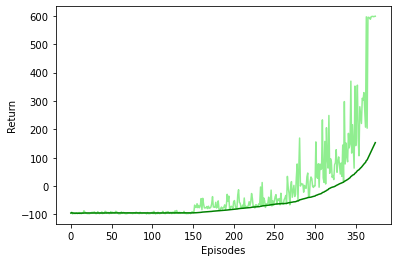

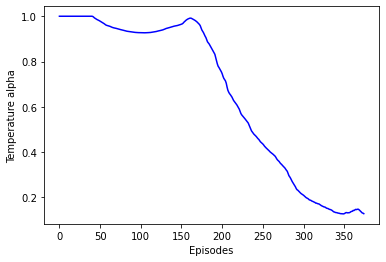

In [9]:
plot_learning_curve(score_history, figure_file_return+'.png', color='lightgreen', avg_color='green', Ylabel='Return')
plot_learning_curve(alpha_history, figure_file_alpha+'.png', color='blue', Ylabel='Temperature alpha')

np.save(figure_file_return, score_history)

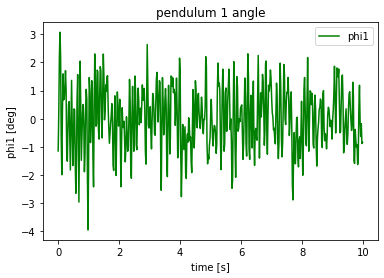

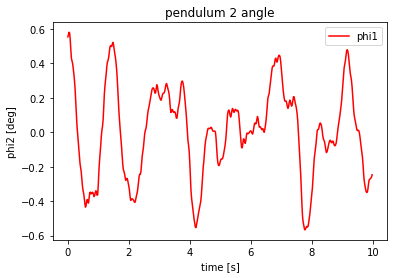

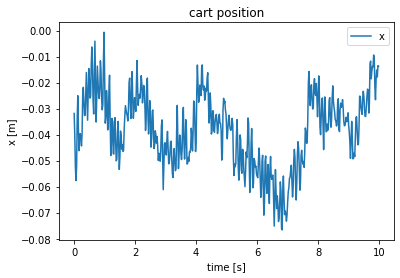

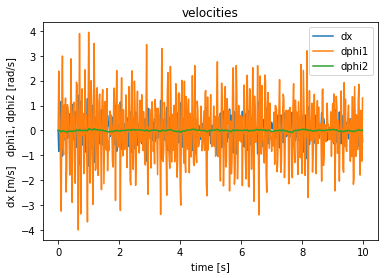

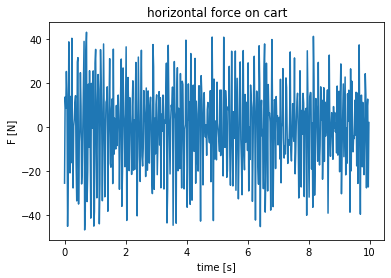

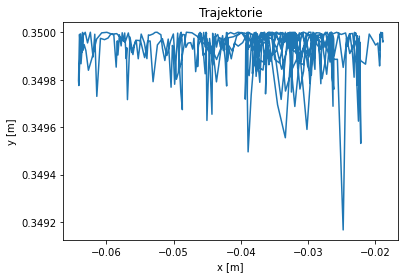

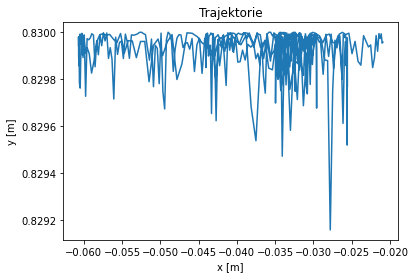

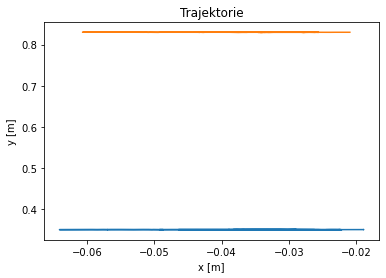

In [10]:
x = []
theta1 = []
theta2 = []
dx = []
dtheta1 = []
dtheta2 = []
force = []

for i in range(1):
    observation = env.reset()
    done = False
    while not done:
        x.append(observation[0])
        theta1.append(observation[1])
        theta2.append(observation[2])
        dx.append(observation[3])
        dtheta1.append(observation[4])
        dtheta2.append(observation[5])
        action = agent.choose_action(observation)
        force.append(action)
        observation_, _, done = env.step(action)
        observation = observation_
    
n_steps = len(x)
t = [env.dt*i for i in range(n_steps)]

plt.plot(t, np.rad2deg(theta1), label='phi1', color='green')
plt.title('pendulum 1 angle')
plt.ylabel('phi1 [deg]')
plt.xlabel('time [s]')
plt.legend()
plt.savefig('plots/' + 'phi_1.png')
plt.show()

plt.plot(t, np.rad2deg(theta2), label='phi1', color='red')
plt.title('pendulum 2 angle')
plt.ylabel('phi2 [deg]')
plt.xlabel('time [s]')
plt.legend()
plt.savefig('plots/' + 'phi_2.png')
plt.show()


plt.plot(t, x, label='x')
plt.title('cart position')
plt.ylabel('x [m]')
plt.xlabel('time [s]')
plt.legend()
plt.savefig('plots/' + 'cart_distance.png')
plt.show()


plt.plot(t, dx, label='dx')
plt.plot(t, dtheta1, label='dphi1')
plt.plot(t, dtheta2, label='dphi2')
plt.title('velocities')
plt.ylabel('dx [m/s]   dphi1, dphi2 [rad/s]')
plt.xlabel('time [s]')
plt.legend()
plt.savefig('plots/' + 'velocities.png')
plt.show()


plt.plot(t, force)
plt.title('horizontal force on cart')
plt.ylabel('F [N]')
plt.xlabel('time [s]')
plt.savefig('plots/' + 'control_variable.png')
plt.show()


l1, l2 = 0.35, 0.48

x_u = [x[i] + l1*sin(theta1[i]) for i in range(len(x))]
y_u = [l1*cos(theta1[i]) for i in range(len(x))]

x_o = [x[i] + l1*sin(theta1[i]) + l2*sin(theta2[i]) for i in range(len(x))]
y_o = [l1*cos(theta1[i]) + l2*cos(theta2[i]) for i in range(len(x))]

plt.plot(x_u, y_u)
plt.title('Trajektorie')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

plt.plot(x_o, y_o)
plt.title('Trajektorie')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

plt.plot(x_u, y_u)
plt.plot(x_o, y_o)
plt.title('Trajektorie')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

In [3]:
env = CartPoleBalance(max_force=50.0, max_phi=np.deg2rad(20), max_timesteps=500)  ## 200 funktioniert gut!
for i in range(2):
    observation = env.reset()
    done = False
    while not done:
        env.render()
        #action = agent.choose_action(observation)
        action = np.array([0.0])
        observation_, _, done = env.step(action)
        observation = observation_
env.close()

In [ ]:
#def angle_normalize(x):
#    return (((x+np.pi) % (2*np.pi)) - np.pi)  # for swingup